In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.datasets import make_blobs
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from scipy import ndimage
from sklearn import metrics
from sklearn import neighbors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import gzip
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")


In [3]:
def read_image_file(filename, images):
    width = 28
    height = 28
    N = images

    f = gzip.open(filename, 'r')
    f.read(16) # skip preamble, 16 bytes
    buffer = f.read(width * height * N) # read in "N" images as binary data
    data = np.frombuffer(buffer, dtype='uint8') # convert binary data to integers : 0 - 255
    data = data.reshape(N, width, height, 1) # reshape to Nx28x28x1 (only 1 color channel, b/w)
    f.close()

    return data

def read_label_file(filename, labels):
    N = labels
    
    f = gzip.open(filename, 'r')
    f.read(8) # skip preamble, 8 bytes
    buffer = f.read(N) # read in "N" labels as binary data
    data = np.frombuffer(buffer, dtype='uint8') # convert binary data to integers : 0 - 255
    f.close()
    
    return data

In [4]:
X_train = read_image_file('train-images-idx3-ubyte.gz', 60_000)
y_train = read_label_file('train-labels-idx1-ubyte.gz', 60_000)
X_test = read_image_file('t10k-images-idx3-ubyte.gz', 10_000)
y_test = read_label_file('t10k-labels-idx1-ubyte.gz', 10_000)

X_train = X_train.reshape(60_000, 28*28)
X_test = X_test.reshape(10_000, 28*28)

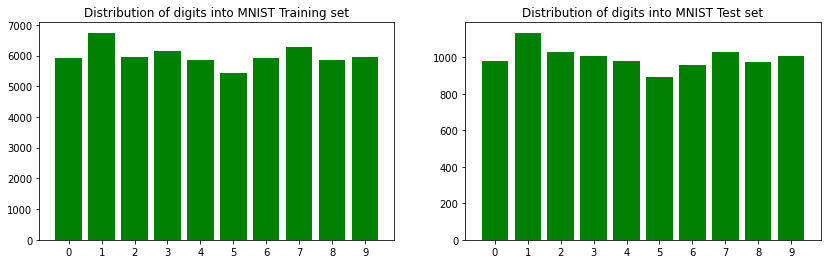

In [8]:
digit_cnt_tr = np.zeros(10)
for item in y_train:
    digit_cnt_tr[item] += 1

digit_cnt_te = np.zeros(10)
for item in y_test:
    digit_cnt_te[item] += 1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

ax1.bar(np.arange(len(digit_cnt_tr)), digit_cnt_tr, color='green')
ax1.set_xticks(np.arange(len(digit_cnt_tr)))
ax1.set_title('Distribution of digits into MNIST Training set')

ax2.bar(np.arange(len(digit_cnt_te)), digit_cnt_te, color='green')
ax2.set_xticks(np.arange(len(digit_cnt_te)))
ax2.set_title('Distribution of digits into MNIST Test set')

plt.show()



MEAN GRAPH


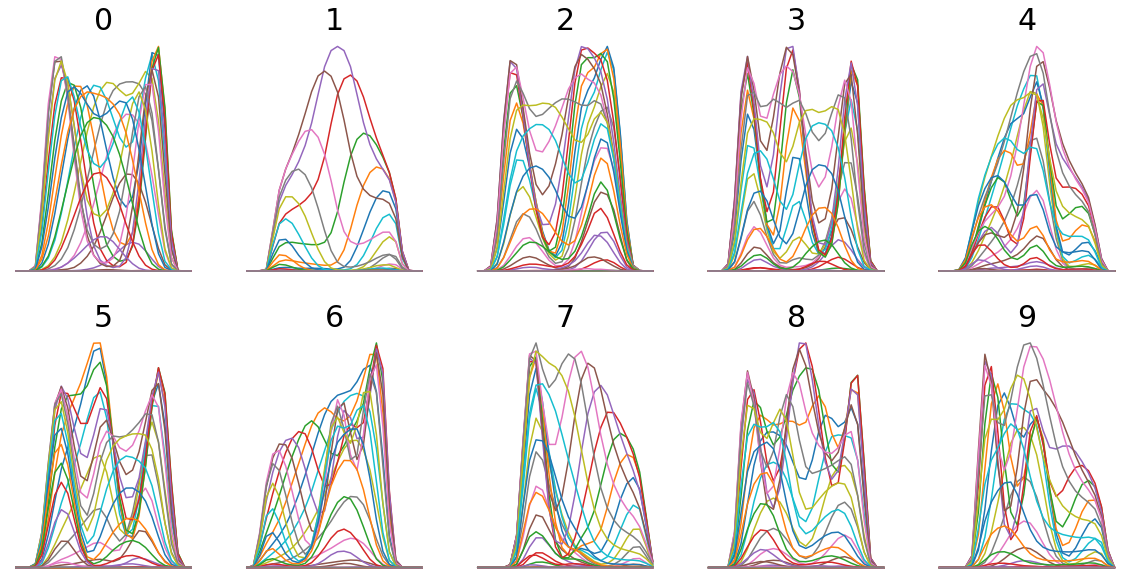

In [9]:
print('\n\nMEAN GRAPH')
X = X_train
y = y_train
u = np.zeros((10, 784))
plt.figure(figsize=(20,10))
for i in range(10):
    u[i] = np.mean(X[y==i], 0)
    plt.subplot(2,5,i+1)
    plt.plot(u[i].reshape(28, 28))
    plt.axis('off')
    plt.title(str(i), fontsize=30)
plt.show()

Train time elapsed: 15.88s
Test time elapsed: 1.54s
Training accuracy: 56.49%
Testing accuracy: 55.58%
                  === Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       980
           1       0.85      0.95      0.90      1135
           2       0.90      0.26      0.40      1032
           3       0.71      0.35      0.47      1010
           4       0.88      0.17      0.29       982
           5       0.55      0.05      0.09       892
           6       0.65      0.93      0.77       958
           7       0.88      0.27      0.42      1028
           8       0.28      0.67      0.40       974
           9       0.37      0.95      0.53      1009

    accuracy                           0.56     10000
   macro avg       0.69      0.55      0.51     10000
weighted avg       0.69      0.56      0.52     10000


Accuracy of Classifier on Test Images:  0.5558


,Accuracy
Digit 0,88.775510
Digit 1,95.066079
Digit 2,25.775194
Digit 3,34.950495
Digit 4,17.107943
Digit 5,4.932735
Digit 6,93.423800
Digit 7,27.237354
Digit 8,66.529774
Digit 9,94.648167


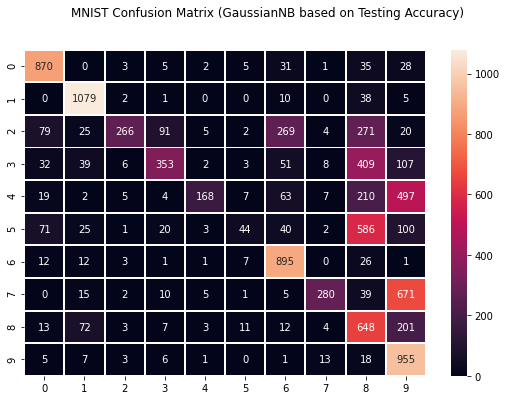

In [36]:
gnb=GaussianNB(priors=None, var_smoothing=1e-09)
gnb.fit(X_train, y_train)

t0 = time.time()
gnb_tre=gnb.predict(X_train)
train_accuracy=gnb.score(X_train,y_train)
print('Train time elapsed: %.2fs' % (time.time()-t0))

t1 = time.time()
gnb_pre=gnb.predict(X_test)
test_accuracy=gnb.score(X_test,y_test)
print('Test time elapsed: %.2fs' % (time.time()-t1))

print('Training accuracy: %0.2f%%' % (train_accuracy*100))
print('Testing accuracy: %0.2f%%' % (test_accuracy*100))


cm = metrics.confusion_matrix(y_test, gnb_pre)
plt.figure(figsize=(9, 6))
sns.heatmap(cm, linewidths=.9, annot=True, fmt='g')
plt.suptitle('MNIST Confusion Matrix (GaussianNB based on Testing Accuracy)')

print('                  === Classification Report ===')
print(metrics.classification_report(y_test, gnb_pre))

acc = metrics.accuracy_score(y_test,gnb_pre)
print('\nAccuracy of Classifier on Test Images: ',acc)

unique, counts = np.unique(y_test, return_counts=True)
counts=counts.tolist()

a=cm.diagonal()
acc={}
# The accuracy is found using unique digits and their respective count from test set and comparing that with confusion matrix
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
for i in range(0,len(a)):
    e=[]
    e.append((a[i]/counts[i])*100)
    acc[i]=e
column=[]
for i in range(0,10):
    column.append('Digit %d'%i)    
acc=pd.DataFrame(acc)
acc.columns=column
acc=acc.T
acc.columns=['Accuracy']
acc



Cross Validation of GaussianNB


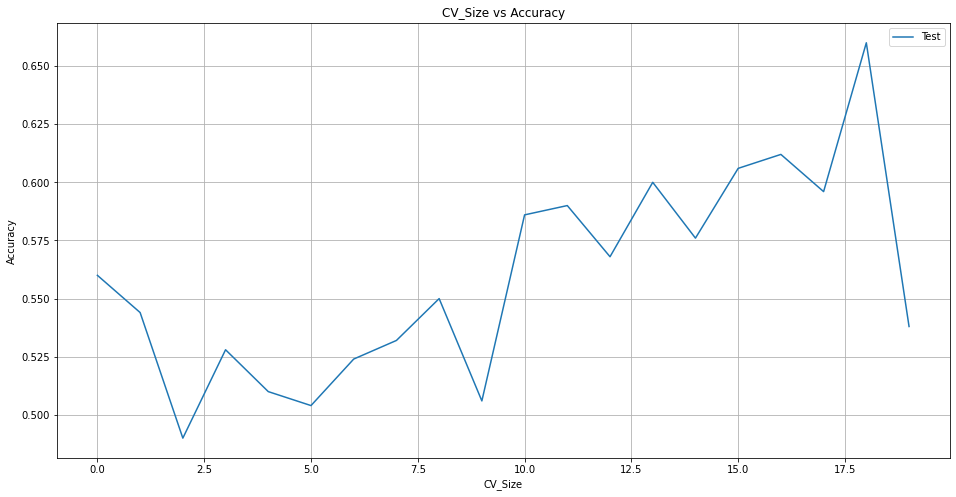

array([0.56 , 0.544, 0.49 , 0.528, 0.51 , 0.504, 0.524, 0.532, 0.55 ,
       0.506, 0.586, 0.59 , 0.568, 0.6  , 0.576, 0.606, 0.612, 0.596,
       0.66 , 0.538])

In [37]:
print('Cross Validation of GaussianNB')
plt.figure(figsize=(16,8))
plt.title('CV_Size vs Accuracy')
plt.xlabel('CV_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(cross_val_score(gnb,X_test,y_test,scoring="accuracy",cv=20))
plt.legend(['Test'])
plt.show()
cross_val_score(gnb,X_test,y_test,scoring="accuracy",cv=20)

0.5737
0.7379166666666667
0.5913


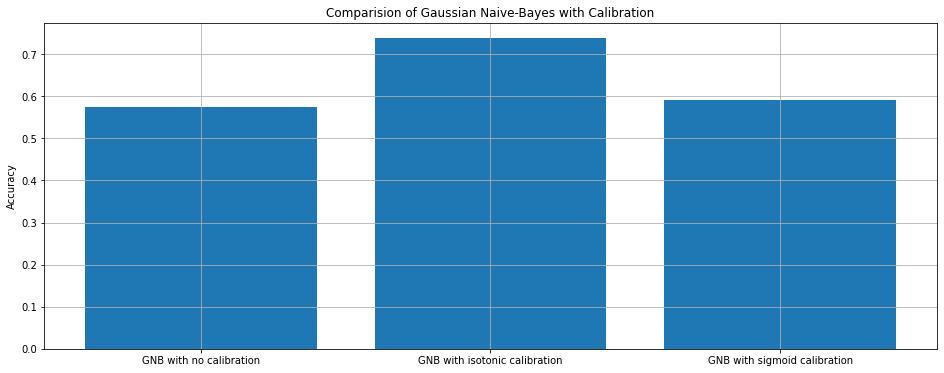

In [38]:
# Gaussian Naive-Bayes with no calibration
a = list()
clf = GaussianNB()
clf.fit(X_test, y_test)  # GaussianNB itself does not support sample-weights
print(clf.score(X_test, y_test))
a.append(clf.score(X_test, y_test))

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=3, method='isotonic')
clf_isotonic.fit(X_train, y_train)
clf_isotonic.score(X_test, y_test)
print(clf_isotonic.score(X_train, y_train))
a.append(clf_isotonic.score(X_train, y_train))

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=3, method='sigmoid')
clf_sigmoid.fit(X_test, y_test,)
print(clf_sigmoid.score(X_test,y_test))
a.append(clf_sigmoid.score(X_test,y_test))

b = ['GNB with no calibration', 'GNB with isotonic calibration', 'GNB with sigmoid calibration']
plt.figure(figsize=(16,6))
plt.grid(True)
plt.bar(b,a)
plt.title('Comparision of Gaussian Naive-Bayes with Calibration')
plt.ylabel('Accuracy')
#plt.xticks()
plt.show()

Train Size: 60000 Test_Size: 10000
[0.5558]
Train Size: 1/10 and took 1.88s
Train Size: 30000 Test_Size: 10000
[0.5558, 0.5475]
Train Size: 2/10 and took 1.53s
Train Size: 15000 Test_Size: 10000
[0.5558, 0.5475, 0.5632]
Train Size: 3/10 and took 1.11s
Train Size: 7500 Test_Size: 10000
[0.5558, 0.5475, 0.5632, 0.5736]
Train Size: 4/10 and took 0.90s
Train Size: 3750 Test_Size: 10000
[0.5558, 0.5475, 0.5632, 0.5736, 0.5647]
Train Size: 5/10 and took 0.82s
Train Size: 1875 Test_Size: 10000
[0.5558, 0.5475, 0.5632, 0.5736, 0.5647, 0.5822]
Train Size: 6/10 and took 0.78s
Train Size: 937 Test_Size: 10000
[0.5558, 0.5475, 0.5632, 0.5736, 0.5647, 0.5822, 0.6602]
Train Size: 7/10 and took 0.94s
Train Size: 468 Test_Size: 10000
[0.5558, 0.5475, 0.5632, 0.5736, 0.5647, 0.5822, 0.6602, 0.5931]
Train Size: 8/10 and took 0.84s
Train Size: 234 Test_Size: 10000
[0.5558, 0.5475, 0.5632, 0.5736, 0.5647, 0.5822, 0.6602, 0.5931, 0.5774]
Train Size: 9/10 and took 0.74s
GaussianNB(priors=None, var_smoothing

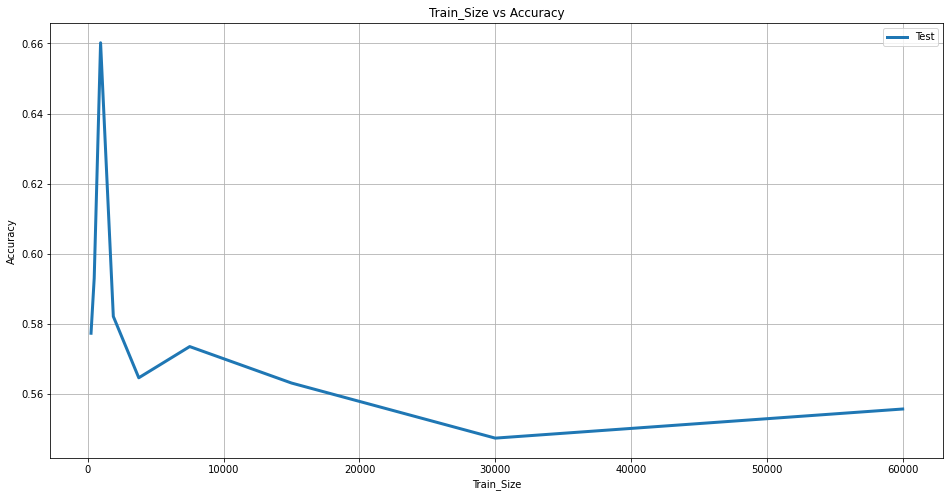

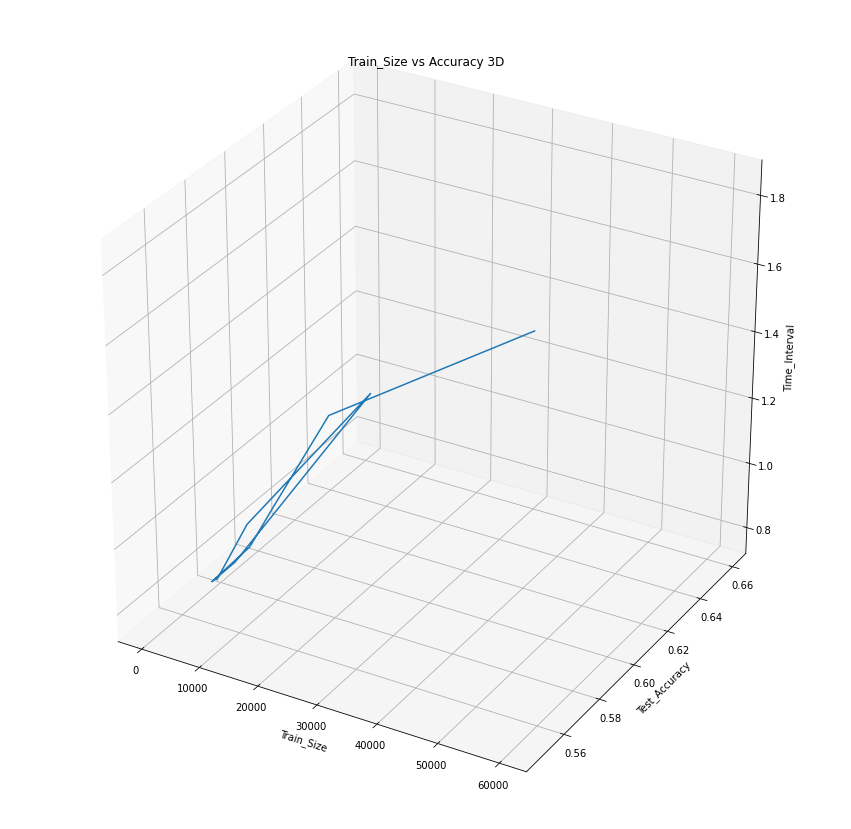

In [8]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
train_size = []
time_interval = []
depth_range = 10
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    train_size.append(Tn_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    gnb_ = GaussianNB(priors=None, var_smoothing=1e-09)
    
    gnb_.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = gnb_.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tn_S = Tn_S/2 
    Tn_S = int(Tn_S)
    time_interval.append(time.time()-ti)
print(gnb_.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Train_Size vs Accuracy')
plt.xlabel('Train_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(train_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Train_Size vs Accuracy 3D')
ax.set_xlabel('Train_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(train_size,test_accuracy,time_interval)

Train Size: 60000 Test_Size: 10000
[0.5558]
Train Size: 1/6 and took 1.77s
Train Size: 60000 Test_Size: 5000
[0.5558, 0.52]
Train Size: 2/6 and took 1.33s
Train Size: 60000 Test_Size: 2500
[0.5558, 0.52, 0.5164]
Train Size: 3/6 and took 1.22s
Train Size: 60000 Test_Size: 1250
[0.5558, 0.52, 0.5164, 0.516]
Train Size: 4/6 and took 1.20s
Train Size: 60000 Test_Size: 625
[0.5558, 0.52, 0.5164, 0.516, 0.5264]
Train Size: 5/6 and took 1.02s
GaussianNB(priors=None, var_smoothing=1e-09)
Time elapsed: 7.30s


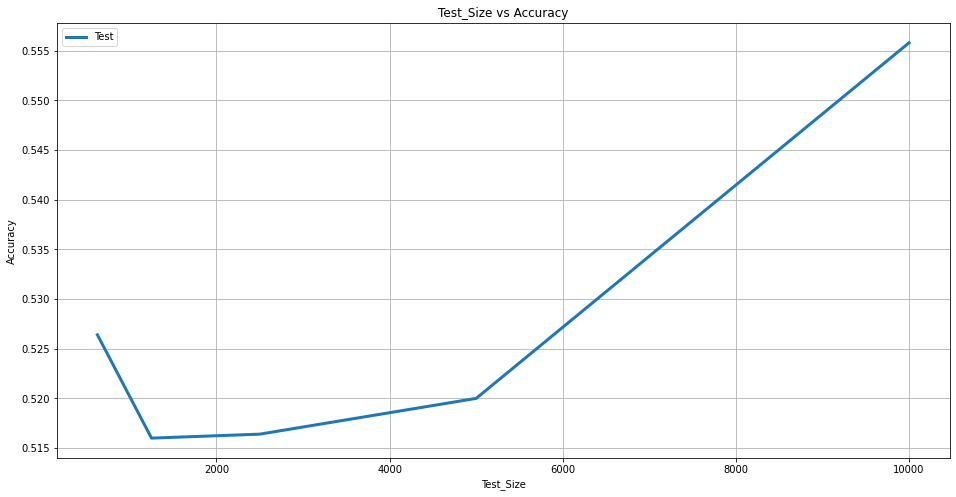

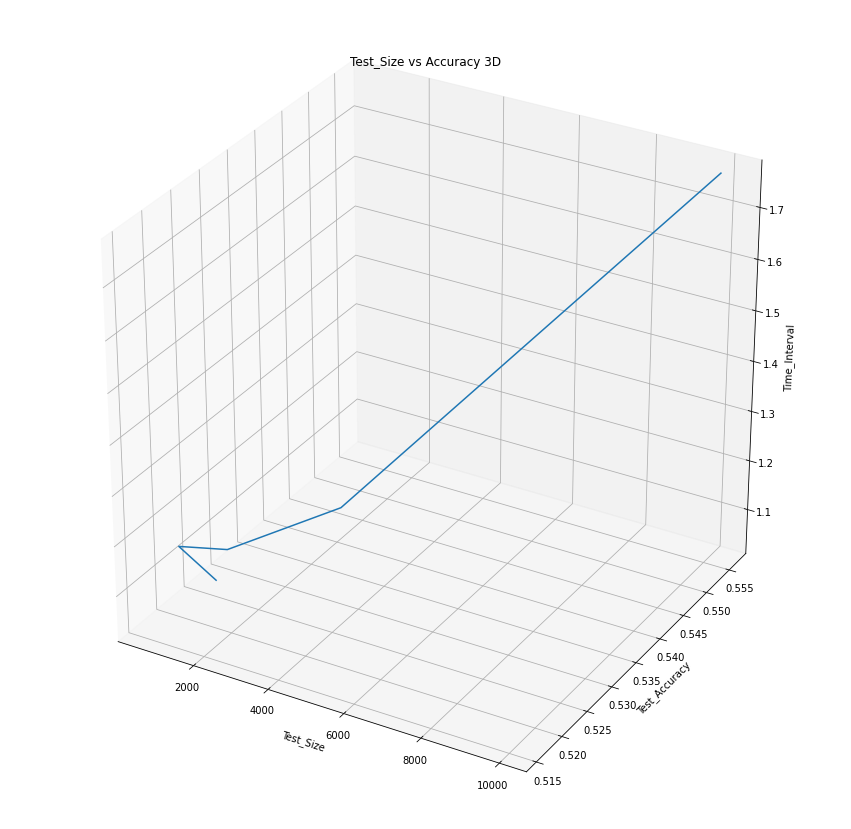

In [9]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
test_size = []
time_interval = []
depth_range = 6
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    test_size.append(Tt_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    clf_dt_depth = GaussianNB(priors=None, var_smoothing=1e-09)
    
    clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = clf_dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tt_S = Tt_S/2 
    Tt_S = int(Tt_S)
    time_interval.append(time.time()-ti)
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Test_Size vs Accuracy')
plt.xlabel('Test_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(test_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Test_Size vs Accuracy 3D')
ax.set_xlabel('Test_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(test_size,test_accuracy,time_interval)

# MNB 

Train time elapsed: 0.82s
Test time elapsed: 0.11s
Training accuracy: 82.53%
Testing accuracy: 83.65%
                  === Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       980
           1       0.91      0.93      0.92      1135
           2       0.90      0.83      0.86      1032
           3       0.80      0.84      0.82      1010
           4       0.84      0.75      0.79       982
           5       0.86      0.66      0.75       892
           6       0.89      0.90      0.89       958
           7       0.94      0.84      0.88      1028
           8       0.66      0.80      0.72       974
           9       0.71      0.86      0.78      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.83      0.84     10000
weighted avg       0.84      0.84      0.84     10000


Accuracy of Classifier on Test Images:  0.8365


,Accuracy
Digit 0,93.061224
Digit 1,93.480176
Digit 2,83.139535
Digit 3,84.257426
Digit 4,74.541752
Digit 5,66.143498
Digit 6,89.770355
Digit 7,83.754864
Digit 8,79.774127
Digit 9,85.530228


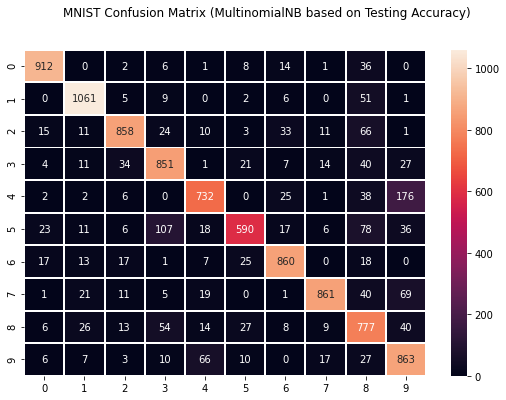

In [45]:
X_train = read_image_file('train-images-idx3-ubyte.gz', 60_000)
y_train = read_label_file('train-labels-idx1-ubyte.gz', 60_000)
X_test = read_image_file('t10k-images-idx3-ubyte.gz', 10_000)
y_test = read_label_file('t10k-labels-idx1-ubyte.gz', 10_000)

X_train = X_train.reshape(60_000, 28*28)
X_test = X_test.reshape(10_000, 28*28)

mnb=MultinomialNB()
mnb.fit(X_train, y_train)

t0 = time.time()
mnb_tre=mnb.predict(X_train)
train_accuracy=mnb.score(X_train,y_train)
print('Train time elapsed: %.2fs' % (time.time()-t0))

t1 = time.time()
mnb_pre=mnb.predict(X_test)
test_accuracy=mnb.score(X_test,y_test)
print('Test time elapsed: %.2fs' % (time.time()-t1))

print('Training accuracy: %0.2f%%' % (train_accuracy*100))
print('Testing accuracy: %0.2f%%' % (test_accuracy*100))


cm = metrics.confusion_matrix(y_test, mnb_pre)
plt.figure(figsize=(9, 6))
sns.heatmap(cm, linewidths=.9, annot=True, fmt='g')
plt.suptitle('MNIST Confusion Matrix (MultinomialNB based on Testing Accuracy)')

print('                  === Classification Report ===')
print(metrics.classification_report(y_test, mnb_pre))

acc = metrics.accuracy_score(y_test,mnb_pre)
print('\nAccuracy of Classifier on Test Images: ',acc)

unique, counts = np.unique(y_test, return_counts=True)
counts=counts.tolist()

a=cm.diagonal()
acc={}
# The accuracy is found using unique digits and their respective count from test set and comparing that with confusion matrix
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
for i in range(0,len(a)):
    e=[]
    e.append((a[i]/counts[i])*100)
    acc[i]=e
column=[]
for i in range(0,10):
    column.append('Digit %d'%i)    
acc=pd.DataFrame(acc)
acc.columns=column
acc=acc.T
acc.columns=['Accuracy']
acc




Cross Validation of MultinomialNB


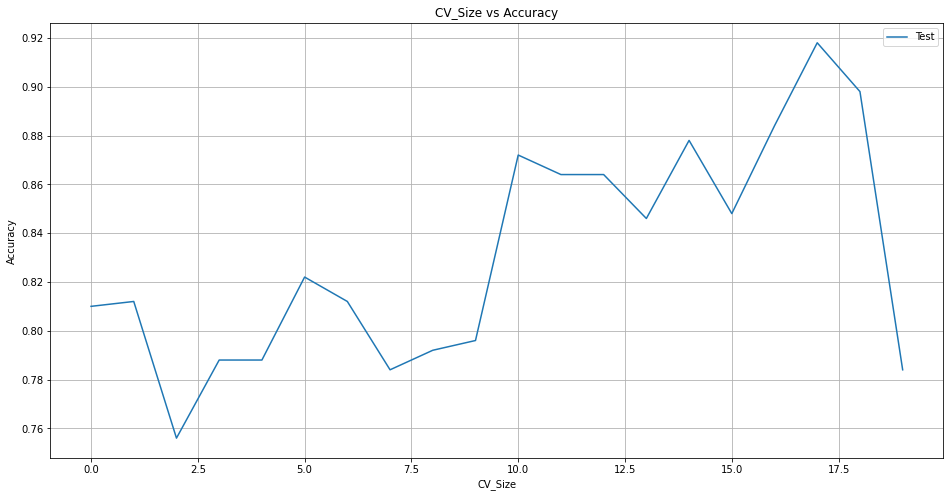

Max Accuracy: 0.918


array([0.81 , 0.812, 0.756, 0.788, 0.788, 0.822, 0.812, 0.784, 0.792,
       0.796, 0.872, 0.864, 0.864, 0.846, 0.878, 0.848, 0.884, 0.918,
       0.898, 0.784])

In [46]:
print('Cross Validation of MultinomialNB')
plt.figure(figsize=(16,8))
plt.title('CV_Size vs Accuracy')
plt.xlabel('CV_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(cross_val_score(mnb,X_test,y_test,scoring="accuracy",cv=20))
plt.legend(['Test'])
plt.show()
print('Max Accuracy: ' + str(max(cross_val_score(mnb,X_test,y_test,scoring="accuracy",cv=20))))
cross_val_score(mnb,X_test,y_test,scoring="accuracy",cv=20)


0.8399
0.8277
0.8426


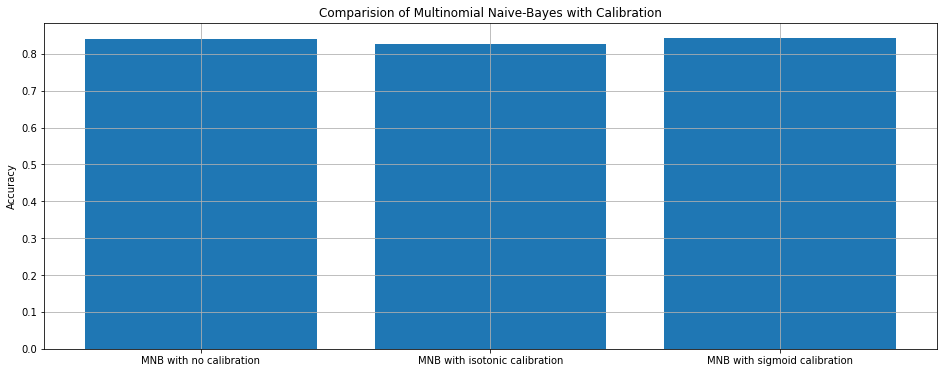

In [47]:
# Multinomial Naive-Bayes with no calibration
a = list()
clf = MultinomialNB()
clf.fit(X_test, y_test)  # MultinomialNB itself does not support sample-weights
print(clf.score(X_test, y_test))
a.append(clf.score(X_test, y_test))

# Multinomial Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=3, method='isotonic')
clf_isotonic.fit(X_train, y_train)
clf_isotonic.score(X_test, y_test)
print(clf_isotonic.score(X_train, y_train))
a.append(clf_isotonic.score(X_train, y_train))

# Multinomial Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=3, method='sigmoid')
clf_sigmoid.fit(X_test, y_test,)
print(clf_sigmoid.score(X_test,y_test))
a.append(clf_sigmoid.score(X_test,y_test))

b = ['MNB with no calibration', 'MNB with isotonic calibration', 'MNB with sigmoid calibration']
plt.figure(figsize=(16,6))
plt.grid(True)
plt.bar(b,a)
plt.title('Comparision of Multinomial Naive-Bayes with Calibration')
plt.ylabel('Accuracy')
#plt.xticks()
plt.show()

Train Size: 60000 Test_Size: 10000
[0.8365]
Train Size: 1/10 and took 13.54s
Train Size: 30000 Test_Size: 10000
[0.8365, 0.8385]
Train Size: 2/10 and took 4.55s
Train Size: 15000 Test_Size: 10000
[0.8365, 0.8385, 0.8348]
Train Size: 3/10 and took 2.39s
Train Size: 7500 Test_Size: 10000
[0.8365, 0.8385, 0.8348, 0.8337]
Train Size: 4/10 and took 1.06s
Train Size: 3750 Test_Size: 10000
[0.8365, 0.8385, 0.8348, 0.8337, 0.8307]
Train Size: 5/10 and took 0.57s
Train Size: 1875 Test_Size: 10000
[0.8365, 0.8385, 0.8348, 0.8337, 0.8307, 0.8147]
Train Size: 6/10 and took 0.34s
Train Size: 937 Test_Size: 10000
[0.8365, 0.8385, 0.8348, 0.8337, 0.8307, 0.8147, 0.8047]
Train Size: 7/10 and took 0.23s
Train Size: 468 Test_Size: 10000
[0.8365, 0.8385, 0.8348, 0.8337, 0.8307, 0.8147, 0.8047, 0.7685]
Train Size: 8/10 and took 0.15s
Train Size: 234 Test_Size: 10000
[0.8365, 0.8385, 0.8348, 0.8337, 0.8307, 0.8147, 0.8047, 0.7685, 0.7291]
Train Size: 9/10 and took 0.13s
MultinomialNB(alpha=1.0, class_prior

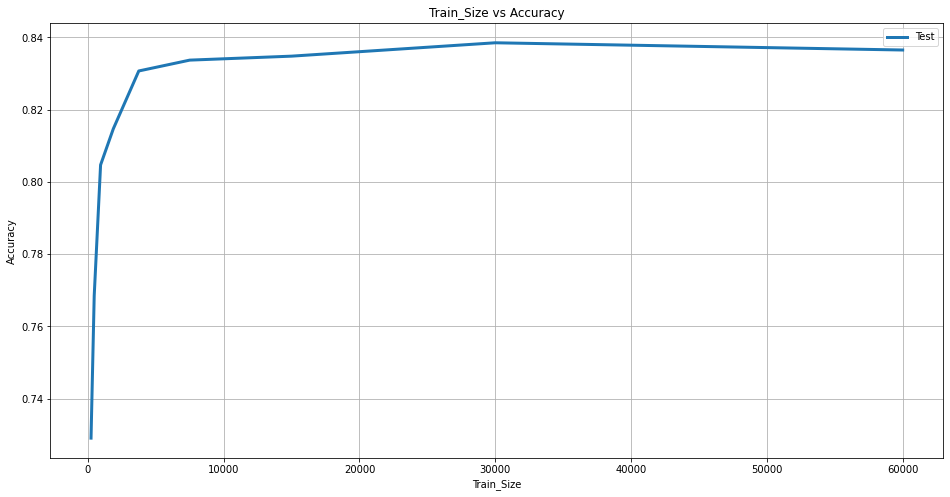

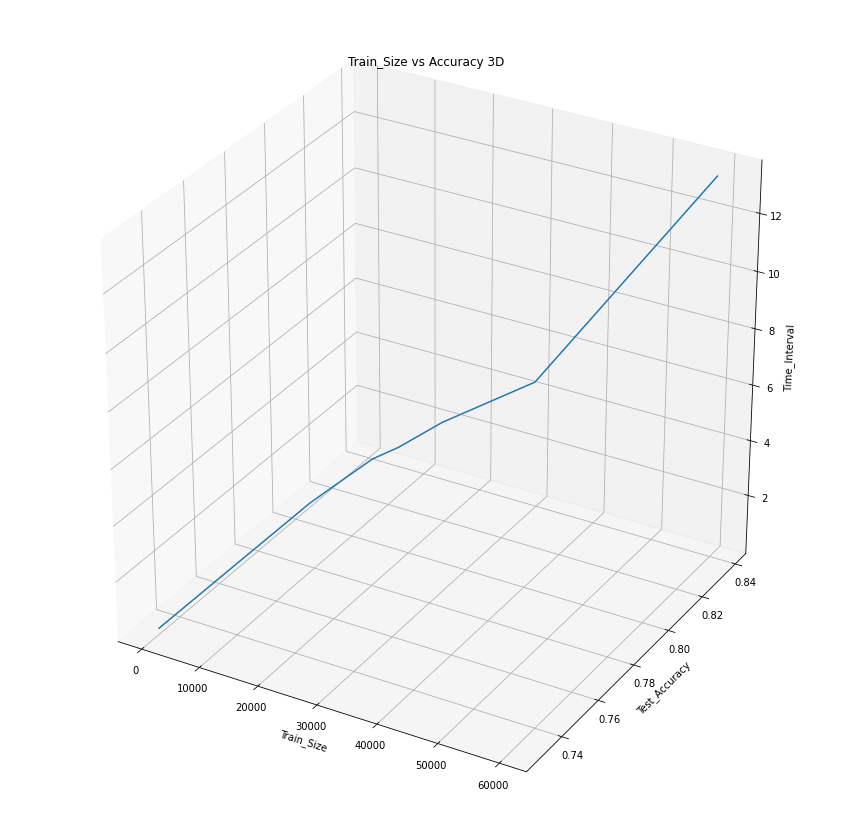

In [48]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
train_size = []
time_interval = []
depth_range = 10
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    train_size.append(Tn_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    clf_dt_depth = MultinomialNB()
    
    clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = clf_dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tn_S = Tn_S/2 
    Tn_S = int(Tn_S)
    time_interval.append(time.time()-ti)
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Train_Size vs Accuracy')
plt.xlabel('Train_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(train_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Train_Size vs Accuracy 3D')
ax.set_xlabel('Train_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(train_size,test_accuracy,time_interval)

Train Size: 60000 Test_Size: 10000
[0.8365]
Train Size: 1/6 and took 11.90s
Train Size: 60000 Test_Size: 5000
[0.8365, 0.794]
Train Size: 2/6 and took 11.54s
Train Size: 60000 Test_Size: 2500
[0.8365, 0.794, 0.7908]
Train Size: 3/6 and took 13.25s
Train Size: 60000 Test_Size: 1250
[0.8365, 0.794, 0.7908, 0.796]
Train Size: 4/6 and took 13.77s
Train Size: 60000 Test_Size: 625
[0.8365, 0.794, 0.7908, 0.796, 0.8048]
Train Size: 5/6 and took 13.08s
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Time elapsed: 74.66s


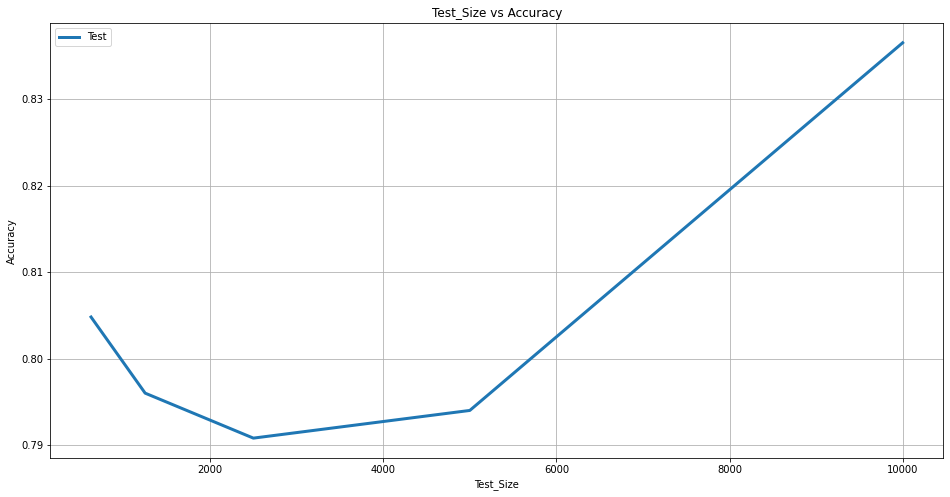

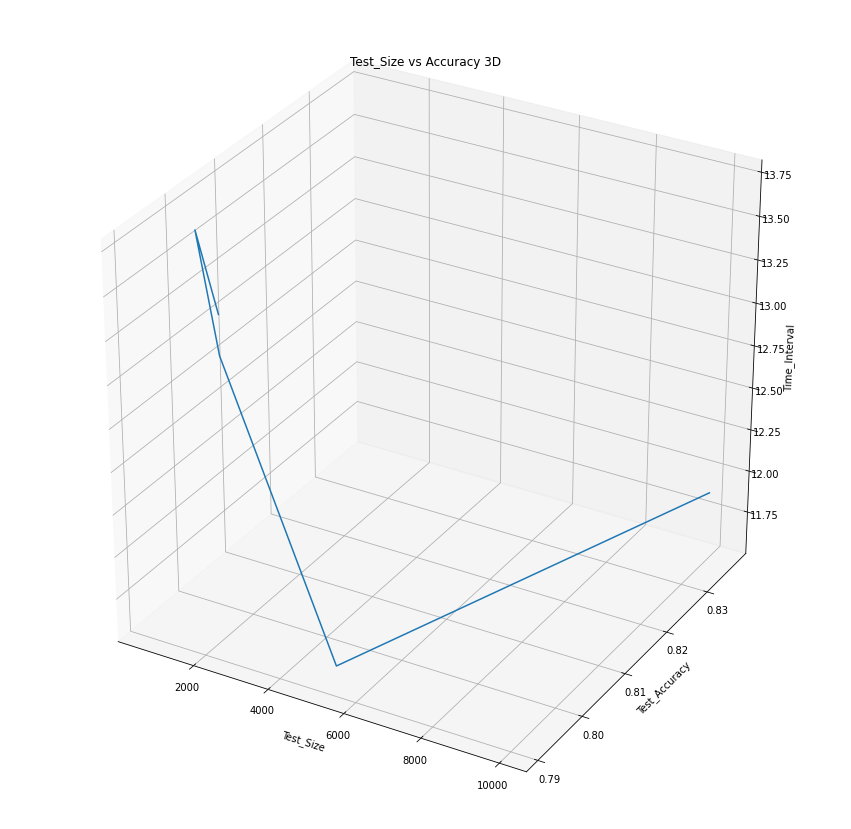

In [49]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
test_size = []
time_interval = []
depth_range = 6
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    test_size.append(Tt_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    clf_dt_depth = MultinomialNB()
    
    clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = clf_dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tt_S = Tt_S/2 
    Tt_S = int(Tt_S)
    time_interval.append(time.time()-ti)
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Test_Size vs Accuracy')
plt.xlabel('Test_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(test_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Test_Size vs Accuracy 3D')
ax.set_xlabel('Test_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(test_size,test_accuracy,time_interval)

# CNB

Train time elapsed: 0.69s
Test time elapsed: 0.09s
Training accuracy: 71.54%
Testing accuracy: 72.85%
                  === Classification Report ===
              precision    recall  f1-score   support

           0       0.63      0.91      0.75       980
           1       0.72      0.98      0.83      1135
           2       0.86      0.73      0.79      1032
           3       0.67      0.82      0.74      1010
           4       0.92      0.62      0.74       982
           5       0.84      0.48      0.61       892
           6       0.78      0.84      0.81       958
           7       0.63      0.89      0.74      1028
           8       0.83      0.38      0.52       974
           9       0.70      0.57      0.63      1009

    accuracy                           0.73     10000
   macro avg       0.76      0.72      0.71     10000
weighted avg       0.76      0.73      0.72     10000


Accuracy of Classifier on Test Images:  0.7285


,Accuracy
Digit 0,91.428571
Digit 1,97.621145
Digit 2,72.577519
Digit 3,82.475248
Digit 4,61.608961
Digit 5,47.757848
Digit 6,83.820459
Digit 7,89.299611
Digit 8,37.987680
Digit 9,57.185332


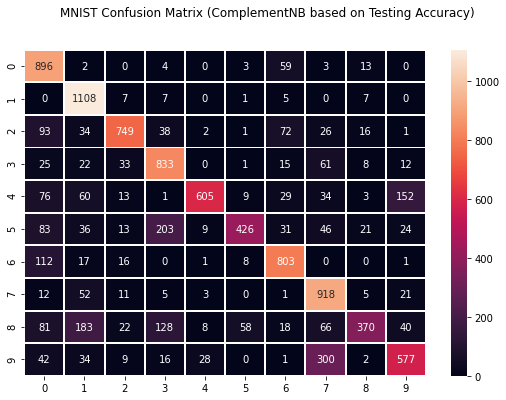

In [50]:
X_train = read_image_file('train-images-idx3-ubyte.gz', 60_000)
y_train = read_label_file('train-labels-idx1-ubyte.gz', 60_000)
X_test = read_image_file('t10k-images-idx3-ubyte.gz', 10_000)
y_test = read_label_file('t10k-labels-idx1-ubyte.gz', 10_000)

X_train = X_train.reshape(60_000, 28*28)
X_test = X_test.reshape(10_000, 28*28)

cnb=ComplementNB()
cnb.fit(X_train, y_train)

t0 = time.time()
cnb_tre=cnb.predict(X_train)
train_accuracy=cnb.score(X_train,y_train)
print('Train time elapsed: %.2fs' % (time.time()-t0))

t1 = time.time()
cnb_pre=cnb.predict(X_test)
test_accuracy=cnb.score(X_test,y_test)
print('Test time elapsed: %.2fs' % (time.time()-t1))

print('Training accuracy: %0.2f%%' % (train_accuracy*100))
print('Testing accuracy: %0.2f%%' % (test_accuracy*100))


cm = metrics.confusion_matrix(y_test, cnb_pre)
plt.figure(figsize=(9, 6))
sns.heatmap(cm, linewidths=.9, annot=True, fmt='g')
plt.suptitle('MNIST Confusion Matrix (ComplementNB based on Testing Accuracy)')

print('                  === Classification Report ===')
print(metrics.classification_report(y_test, cnb_pre))

acc = metrics.accuracy_score(y_test,cnb_pre)
print('\nAccuracy of Classifier on Test Images: ',acc)

unique, counts = np.unique(y_test, return_counts=True)
counts=counts.tolist()

a=cm.diagonal()
acc={}
# The accuracy is found using unique digits and their respective count from test set and comparing that with confusion matrix
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
for i in range(0,len(a)):
    e=[]
    e.append((a[i]/counts[i])*100)
    acc[i]=e
column=[]
for i in range(0,10):
    column.append('Digit %d'%i)    
acc=pd.DataFrame(acc)
acc.columns=column
acc=acc.T
acc.columns=['Accuracy']
acc




Cross Validation of ComplementNB


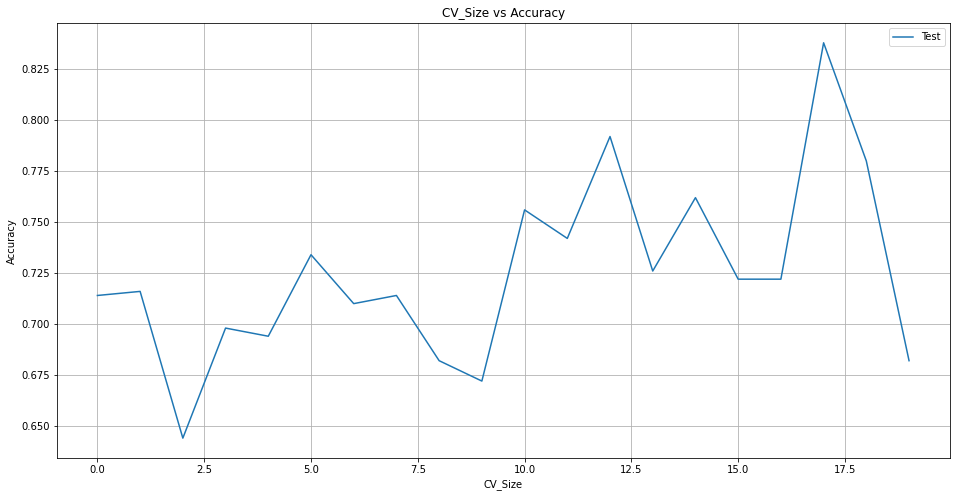

Max Accuracy: 0.838


array([0.714, 0.716, 0.644, 0.698, 0.694, 0.734, 0.71 , 0.714, 0.682,
       0.672, 0.756, 0.742, 0.792, 0.726, 0.762, 0.722, 0.722, 0.838,
       0.78 , 0.682])

In [51]:
print('Cross Validation of ComplementNB')
plt.figure(figsize=(16,8))
plt.title('CV_Size vs Accuracy')
plt.xlabel('CV_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(cross_val_score(cnb,X_test,y_test,scoring="accuracy",cv=20))
plt.legend(['Test'])
plt.show()
print('Max Accuracy: ' + str(max(cross_val_score(cnb,X_test,y_test,scoring="accuracy",cv=20))))
cross_val_score(cnb,X_test,y_test,scoring="accuracy",cv=20)



0.7331
0.7300333333333333
0.7356


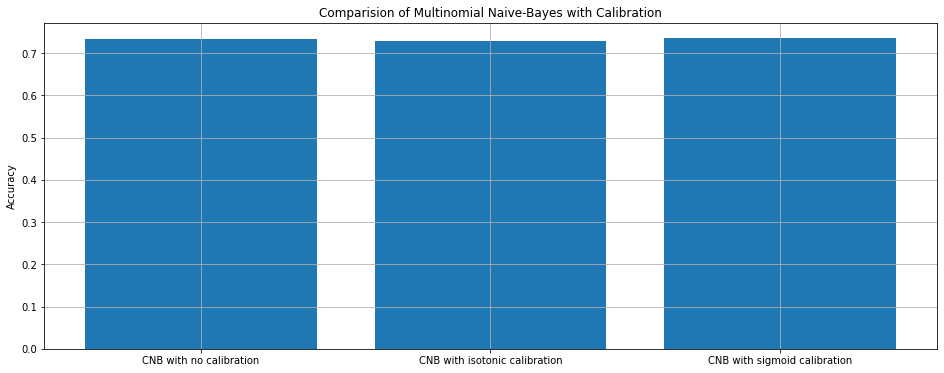

In [52]:
# Complement Naive-Bayes with no calibration
a = list()
clf = ComplementNB()
clf.fit(X_test, y_test)  # MultinomialNB itself does not support sample-weights
print(clf.score(X_test, y_test))
a.append(clf.score(X_test, y_test))

# Complement Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=3, method='isotonic')
clf_isotonic.fit(X_train, y_train)
clf_isotonic.score(X_test, y_test)
print(clf_isotonic.score(X_train, y_train))
a.append(clf_isotonic.score(X_train, y_train))

# Complement Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=3, method='sigmoid')
clf_sigmoid.fit(X_test, y_test,)
print(clf_sigmoid.score(X_test,y_test))
a.append(clf_sigmoid.score(X_test,y_test))

b = ['CNB with no calibration', 'CNB with isotonic calibration', 'CNB with sigmoid calibration']
plt.figure(figsize=(16,6))
plt.grid(True)
plt.bar(b,a)
plt.title('Comparision of Multinomial Naive-Bayes with Calibration')
plt.ylabel('Accuracy')
#plt.xticks()
plt.show()

Train Size: 60000 Test_Size: 10000
[0.7285]
Train Size: 1/10 and took 14.81s
Train Size: 30000 Test_Size: 10000
[0.7285, 0.7279]
Train Size: 2/10 and took 6.34s
Train Size: 15000 Test_Size: 10000
[0.7285, 0.7279, 0.7206]
Train Size: 3/10 and took 3.23s
Train Size: 7500 Test_Size: 10000
[0.7285, 0.7279, 0.7206, 0.7226]
Train Size: 4/10 and took 1.09s
Train Size: 3750 Test_Size: 10000
[0.7285, 0.7279, 0.7206, 0.7226, 0.7236]
Train Size: 5/10 and took 0.58s
Train Size: 1875 Test_Size: 10000
[0.7285, 0.7279, 0.7206, 0.7226, 0.7236, 0.7068]
Train Size: 6/10 and took 0.32s
Train Size: 937 Test_Size: 10000
[0.7285, 0.7279, 0.7206, 0.7226, 0.7236, 0.7068, 0.7031]
Train Size: 7/10 and took 0.20s
Train Size: 468 Test_Size: 10000
[0.7285, 0.7279, 0.7206, 0.7226, 0.7236, 0.7068, 0.7031, 0.6585]
Train Size: 8/10 and took 0.15s
Train Size: 234 Test_Size: 10000
[0.7285, 0.7279, 0.7206, 0.7226, 0.7236, 0.7068, 0.7031, 0.6585, 0.6358]
Train Size: 9/10 and took 0.12s
ComplementNB(alpha=1.0, class_prior=

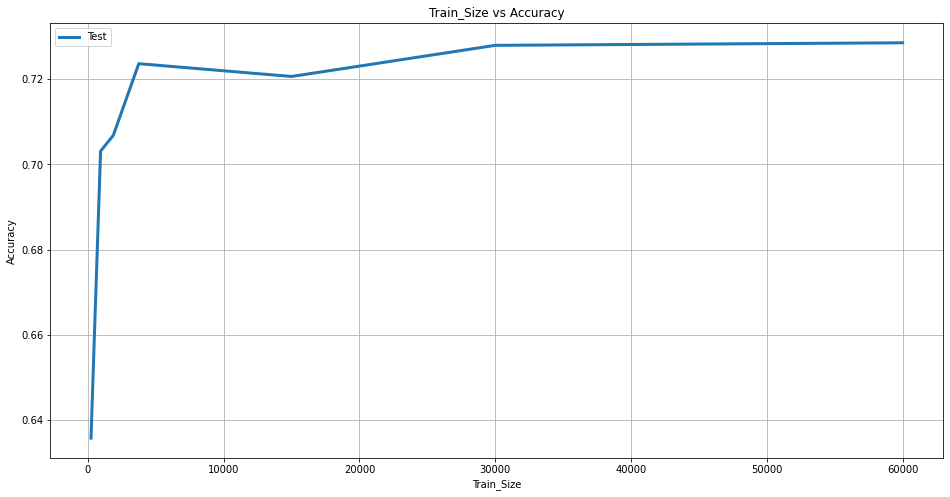

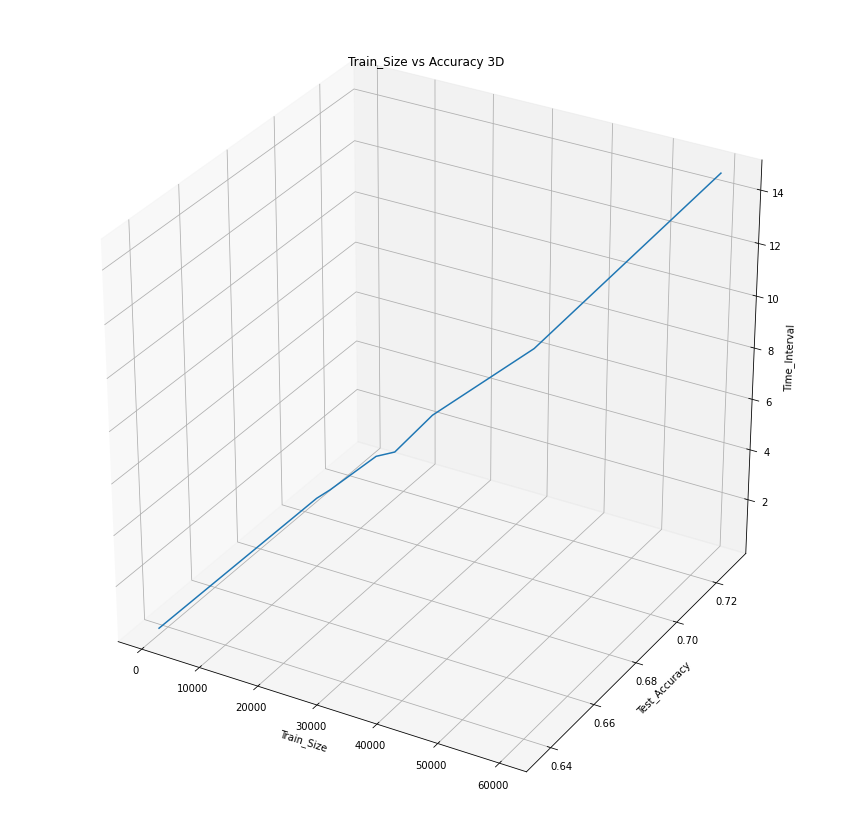

In [53]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
train_size = []
time_interval = []
depth_range = 10
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    train_size.append(Tn_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    clf_dt_depth = ComplementNB()
    
    clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = clf_dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tn_S = Tn_S/2 
    Tn_S = int(Tn_S)
    time_interval.append(time.time()-ti)
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Train_Size vs Accuracy')
plt.xlabel('Train_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(train_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Train_Size vs Accuracy 3D')
ax.set_xlabel('Train_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(train_size,test_accuracy,time_interval)

Train Size: 60000 Test_Size: 10000
[0.7285]
Train Size: 1/6 and took 16.62s
Train Size: 60000 Test_Size: 5000
[0.7285, 0.6924]
Train Size: 2/6 and took 16.32s
Train Size: 60000 Test_Size: 2500
[0.7285, 0.6924, 0.6924]
Train Size: 3/6 and took 16.82s
Train Size: 60000 Test_Size: 1250
[0.7285, 0.6924, 0.6924, 0.6992]
Train Size: 4/6 and took 16.30s
Train Size: 60000 Test_Size: 625
[0.7285, 0.6924, 0.6924, 0.6992, 0.7056]
Train Size: 5/6 and took 16.53s
ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
Time elapsed: 98.82s


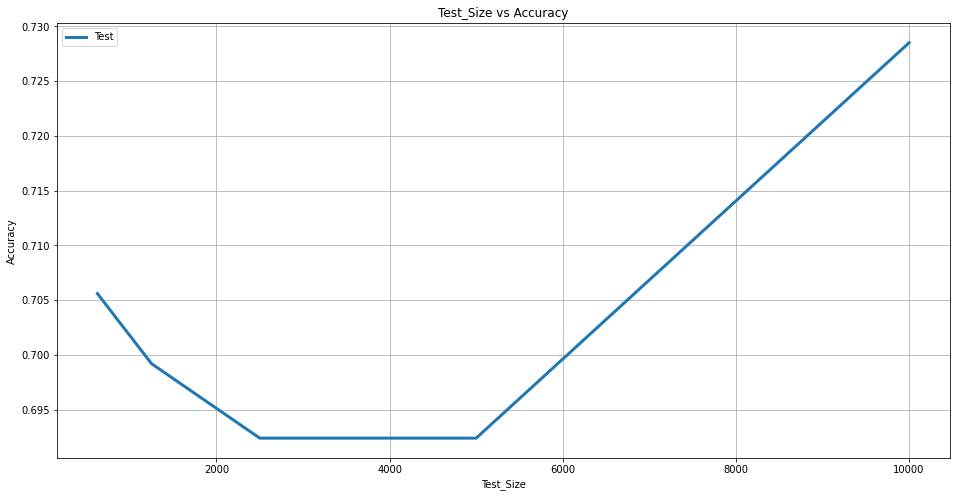

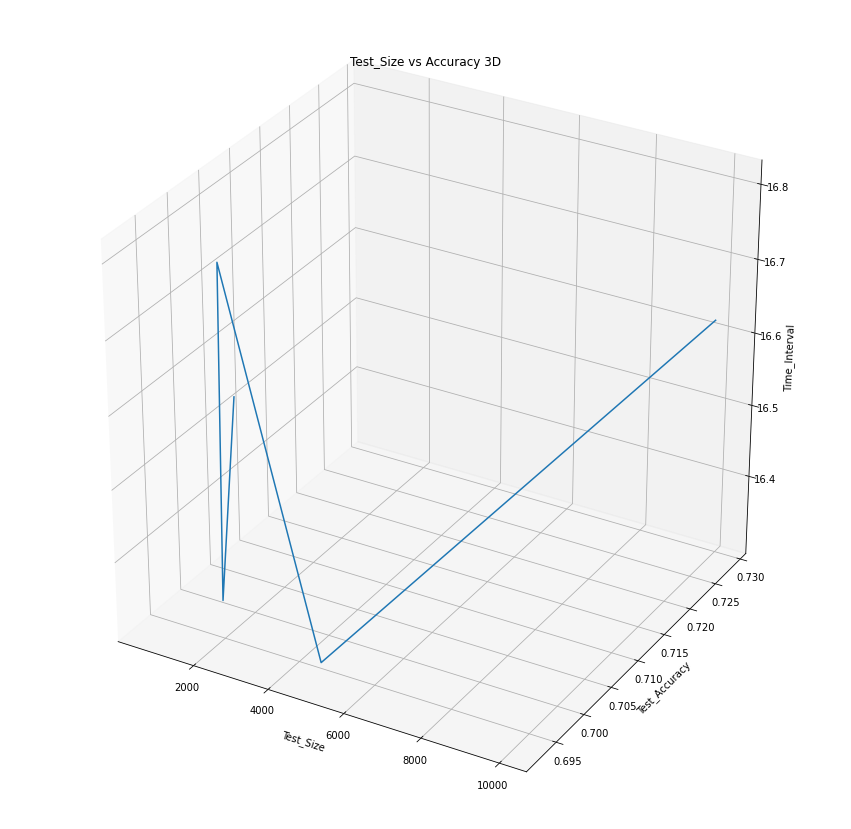

In [54]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
test_size = []
time_interval = []
depth_range = 6
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    test_size.append(Tt_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    clf_dt_depth = ComplementNB()
    
    clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = clf_dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tt_S = Tt_S/2 
    Tt_S = int(Tt_S)
    time_interval.append(time.time()-ti)
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Test_Size vs Accuracy')
plt.xlabel('Test_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(test_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Test_Size vs Accuracy 3D')
ax.set_xlabel('Test_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(test_size,test_accuracy,time_interval)

# BNB

Train time elapsed: 2.21s
Test time elapsed: 0.26s
Training accuracy: 83.12%
Testing accuracy: 84.13%
                  === Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       980
           1       0.90      0.96      0.93      1135
           2       0.89      0.83      0.86      1032
           3       0.76      0.84      0.80      1010
           4       0.83      0.81      0.82       982
           5       0.82      0.70      0.76       892
           6       0.89      0.89      0.89       958
           7       0.93      0.85      0.89      1028
           8       0.75      0.78      0.77       974
           9       0.75      0.84      0.79      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000


Accuracy of Classifier on Test Images:  0.8413


,Accuracy
Digit 0,90.510204
Digit 1,95.594714
Digit 2,82.558140
Digit 3,83.564356
Digit 4,80.957230
Digit 5,70.291480
Digit 6,88.830898
Digit 7,84.727626
Digit 8,77.823409
Digit 9,83.548067


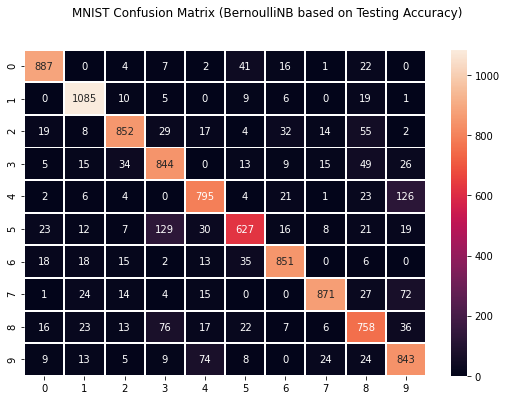

In [10]:
X_train = read_image_file('train-images-idx3-ubyte.gz', 60_000)
y_train = read_label_file('train-labels-idx1-ubyte.gz', 60_000)
X_test = read_image_file('t10k-images-idx3-ubyte.gz', 10_000)
y_test = read_label_file('t10k-labels-idx1-ubyte.gz', 10_000)

X_train = X_train.reshape(60_000, 28*28)
X_test = X_test.reshape(10_000, 28*28)

bnb=BernoulliNB()
bnb.fit(X_train, y_train)

t0 = time.time()
bnb_tre=bnb.predict(X_train)
train_accuracy=bnb.score(X_train,y_train)
print('Train time elapsed: %.2fs' % (time.time()-t0))

t1 = time.time()
bnb_pre=bnb.predict(X_test)
test_accuracy=bnb.score(X_test,y_test)
print('Test time elapsed: %.2fs' % (time.time()-t1))

print('Training accuracy: %0.2f%%' % (train_accuracy*100))
print('Testing accuracy: %0.2f%%' % (test_accuracy*100))


cm = metrics.confusion_matrix(y_test, bnb_pre)
plt.figure(figsize=(9, 6))
sns.heatmap(cm, linewidths=.9, annot=True, fmt='g')
plt.suptitle('MNIST Confusion Matrix (BernoulliNB based on Testing Accuracy)')

print('                  === Classification Report ===')
print(metrics.classification_report(y_test, bnb_pre))

acc = metrics.accuracy_score(y_test,bnb_pre)
print('\nAccuracy of Classifier on Test Images: ',acc)

unique, counts = np.unique(y_test, return_counts=True)
counts=counts.tolist()

a=cm.diagonal()
acc={}
# The accuracy is found using unique digits and their respective count from test set and comparing that with confusion matrix
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
for i in range(0,len(a)):
    e=[]
    e.append((a[i]/counts[i])*100)
    acc[i]=e
column=[]
for i in range(0,10):
    column.append('Digit %d'%i)    
acc=pd.DataFrame(acc)
acc.columns=column
acc=acc.T
acc.columns=['Accuracy']
acc





Cross Validation of BernoulliNB


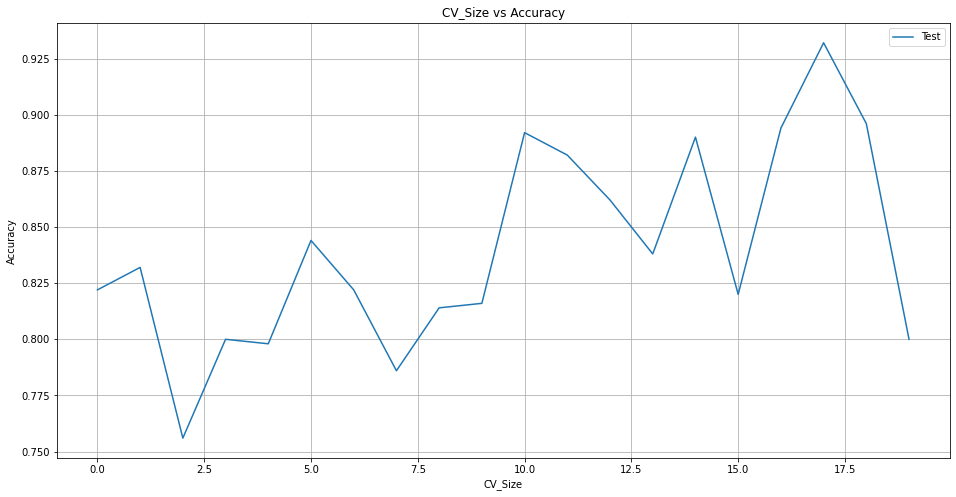

Max Accuracy: 0.932


array([0.822, 0.832, 0.756, 0.8  , 0.798, 0.844, 0.822, 0.786, 0.814,
       0.816, 0.892, 0.882, 0.862, 0.838, 0.89 , 0.82 , 0.894, 0.932,
       0.896, 0.8  ])

In [11]:
print('Cross Validation of BernoulliNB')
plt.figure(figsize=(16,8))
plt.title('CV_Size vs Accuracy')
plt.xlabel('CV_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(cross_val_score(bnb,X_test,y_test,scoring="accuracy",cv=20))
plt.legend(['Test'])
plt.show()
print('Max Accuracy: ' + str(max(cross_val_score(bnb,X_test,y_test,scoring="accuracy",cv=20))))
cross_val_score(bnb,X_test,y_test,scoring="accuracy",cv=20)



0.8472
0.83575
0.8474


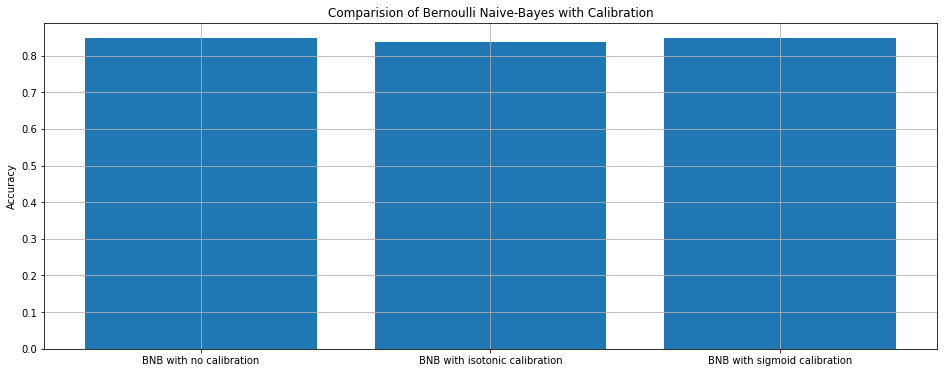

In [57]:
# Complement Naive-Bayes with no calibration
a = list()
clf = BernoulliNB()
clf.fit(X_test, y_test)  # MultinomialNB itself does not support sample-weights
print(clf.score(X_test, y_test))
a.append(clf.score(X_test, y_test))

# Complement Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=3, method='isotonic')
clf_isotonic.fit(X_train, y_train)
clf_isotonic.score(X_test, y_test)
print(clf_isotonic.score(X_train, y_train))
a.append(clf_isotonic.score(X_train, y_train))

# Complement Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=3, method='sigmoid')
clf_sigmoid.fit(X_test, y_test,)
print(clf_sigmoid.score(X_test,y_test))
a.append(clf_sigmoid.score(X_test,y_test))

b = ['BNB with no calibration', 'BNB with isotonic calibration', 'BNB with sigmoid calibration']
plt.figure(figsize=(16,6))
plt.grid(True)
plt.bar(b,a)
plt.title('Comparision of Bernoulli Naive-Bayes with Calibration')
plt.ylabel('Accuracy')
#plt.xticks()
plt.show()

Train Size: 60000 Test_Size: 10000
[0.8413]
Train Size: 1/10 and took 16.70s
Train Size: 30000 Test_Size: 10000
[0.8413, 0.8421]
Train Size: 2/10 and took 8.06s
Train Size: 15000 Test_Size: 10000
[0.8413, 0.8421, 0.8365]
Train Size: 3/10 and took 3.15s
Train Size: 7500 Test_Size: 10000
[0.8413, 0.8421, 0.8365, 0.837]
Train Size: 4/10 and took 1.36s
Train Size: 3750 Test_Size: 10000
[0.8413, 0.8421, 0.8365, 0.837, 0.8289]
Train Size: 5/10 and took 0.77s
Train Size: 1875 Test_Size: 10000
[0.8413, 0.8421, 0.8365, 0.837, 0.8289, 0.8134]
Train Size: 6/10 and took 0.31s
Train Size: 937 Test_Size: 10000
[0.8413, 0.8421, 0.8365, 0.837, 0.8289, 0.8134, 0.805]
Train Size: 7/10 and took 0.35s
Train Size: 468 Test_Size: 10000
[0.8413, 0.8421, 0.8365, 0.837, 0.8289, 0.8134, 0.805, 0.7639]
Train Size: 8/10 and took 0.15s
Train Size: 234 Test_Size: 10000
[0.8413, 0.8421, 0.8365, 0.837, 0.8289, 0.8134, 0.805, 0.7639, 0.7214]
Train Size: 9/10 and took 0.15s
BernoulliNB(alpha=1.0, binarize=0.0, class_pr

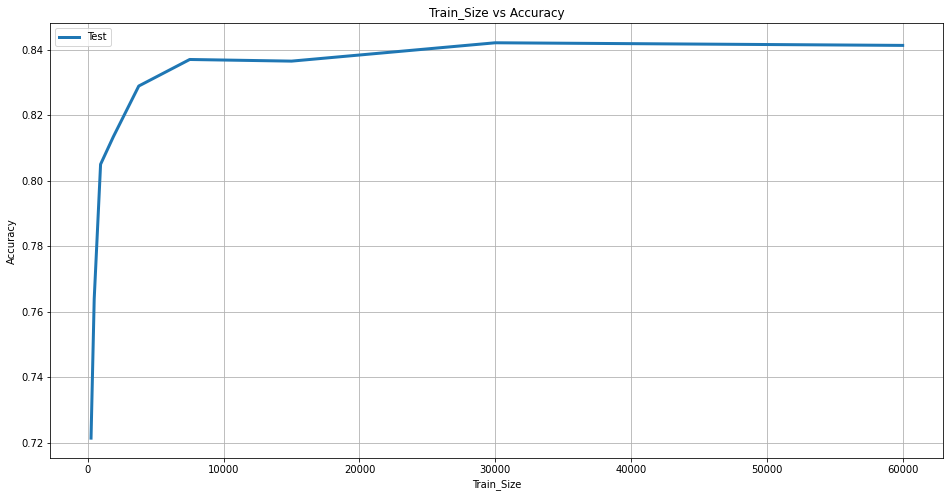

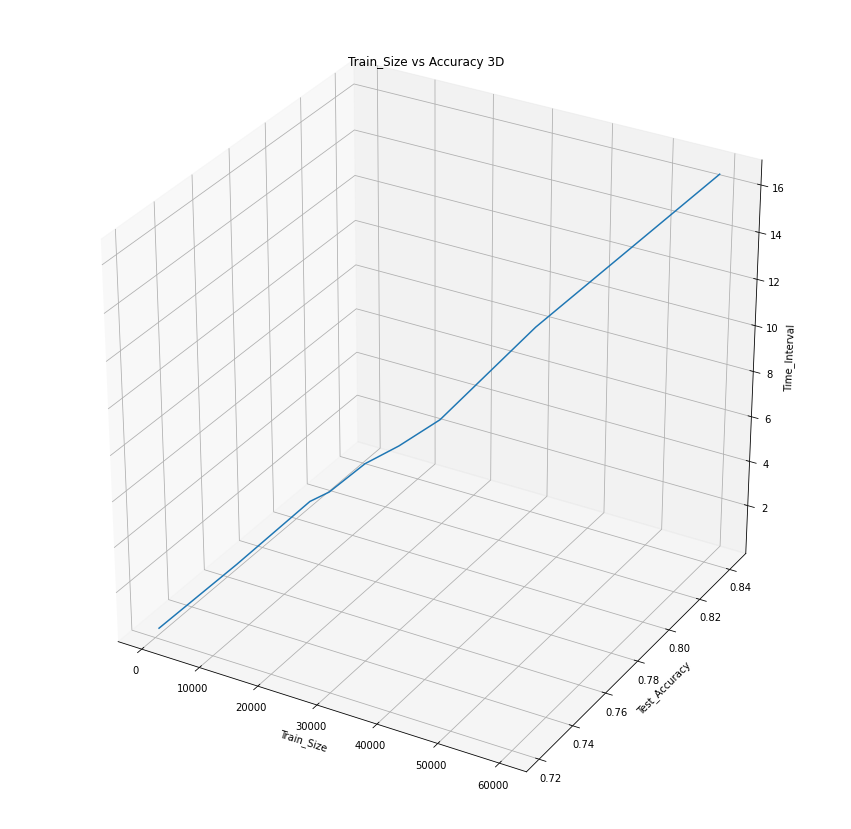

In [58]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
train_size = []
time_interval = []
depth_range = 10
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    train_size.append(Tn_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    clf_dt_depth = BernoulliNB()
    
    clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = clf_dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tn_S = Tn_S/2 
    Tn_S = int(Tn_S)
    time_interval.append(time.time()-ti)
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Train_Size vs Accuracy')
plt.xlabel('Train_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(train_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Train_Size vs Accuracy 3D')
ax.set_xlabel('Train_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(train_size,test_accuracy,time_interval)

Train Size: 60000 Test_Size: 10000
[0.8413]
Train Size: 1/6 and took 15.63s
Train Size: 60000 Test_Size: 5000
[0.8413, 0.7998]
Train Size: 2/6 and took 13.26s
Train Size: 60000 Test_Size: 2500
[0.8413, 0.7998, 0.7956]
Train Size: 3/6 and took 12.86s
Train Size: 60000 Test_Size: 1250
[0.8413, 0.7998, 0.7956, 0.8024]
Train Size: 4/6 and took 13.08s
Train Size: 60000 Test_Size: 625
[0.8413, 0.7998, 0.7956, 0.8024, 0.8096]
Train Size: 5/6 and took 12.83s
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Time elapsed: 80.14s


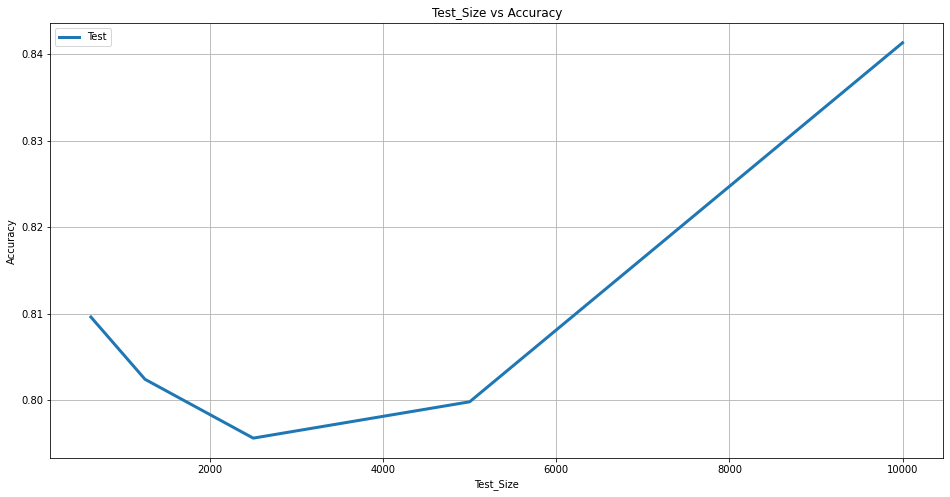

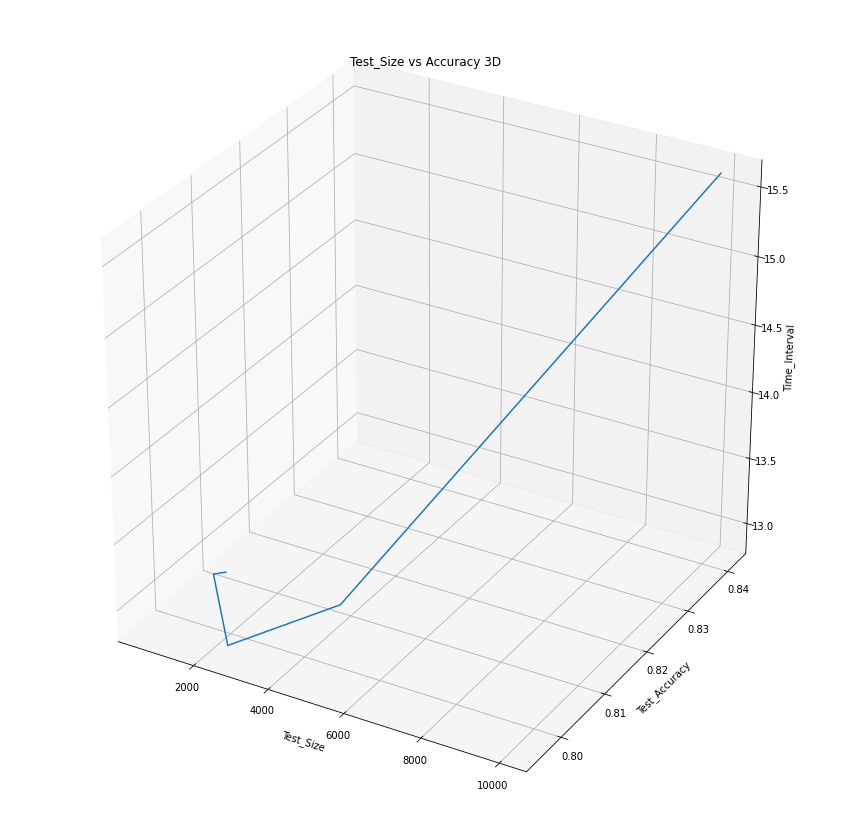

In [59]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
test_size = []
time_interval = []
depth_range = 6
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    test_size.append(Tt_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    clf_dt_depth = BernoulliNB()
    
    clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = clf_dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tt_S = Tt_S/2 
    Tt_S = int(Tt_S)
    time_interval.append(time.time()-ti)
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Test_Size vs Accuracy')
plt.xlabel('Test_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(test_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Test_Size vs Accuracy 3D')
ax.set_xlabel('Test_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(test_size,test_accuracy,time_interval)

# CategoricalNB

Train time elapsed: 14.82s
Test time elapsed: 0.00s
Training accuracy: 89.89%
                  === Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      5923
           1       0.86      0.98      0.92      6742
           2       0.93      0.87      0.90      5958
           3       0.87      0.86      0.87      6131
           4       0.91      0.90      0.91      5842
           5       0.88      0.84      0.86      5421
           6       0.93      0.94      0.93      5918
           7       0.95      0.91      0.93      6265
           8       0.88      0.85      0.87      5851
           9       0.84      0.91      0.88      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.90      0.90      0.90     60000


Accuracy of Classifier on Test Images:  0.8989


,Accuracy
Digit 0,91.018065
Digit 1,98.264610
Digit 2,86.690164
Digit 3,85.956614
Digit 4,90.243067
Digit 5,84.117322
Digit 6,94.035147
Digit 7,90.630487
Digit 8,85.199111
Digit 9,91.158178


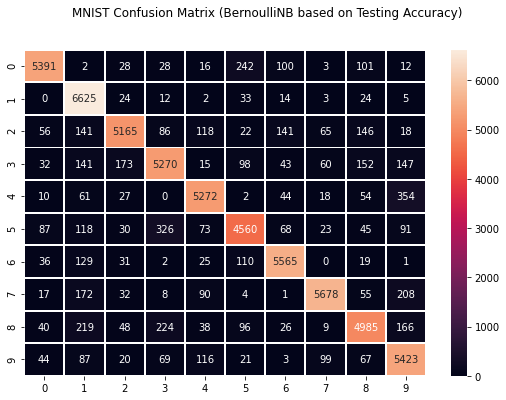

In [60]:
X_train = read_image_file('train-images-idx3-ubyte.gz', 60_000)
y_train = read_label_file('train-labels-idx1-ubyte.gz', 60_000)
X_test = read_image_file('t10k-images-idx3-ubyte.gz', 10_000)
y_test = read_label_file('t10k-labels-idx1-ubyte.gz', 10_000)

X_train = X_train.reshape(60_000, 28*28)
X_test = X_test.reshape(10_000, 28*28)

ctnb=CategoricalNB()
ctnb.fit(X_train, y_train)

t0 = time.time()
ctnb_tre=ctnb.predict(X_train)
train_accuracy=ctnb.score(X_train,y_train)
print('Train time elapsed: %.2fs' % (time.time()-t0))

t1 = time.time()
bnb_pre=ctnb.predict(X_test)
test_accuracy=ctnb.score(X_test,y_test)
print('Test time elapsed: %.2fs' % (time.time()-t1))

print('Training accuracy: %0.2f%%' % (train_accuracy*100))
print('Testing accuracy: %0.2f%%' % (test_accuracy*100))


cm = metrics.confusion_matrix(y_train, ctnb_tre)
plt.figure(figsize=(9, 6))
sns.heatmap(cm, linewidths=.9, annot=True, fmt='g')
plt.suptitle('MNIST Confusion Matrix (BernoulliNB based on Testing Accuracy)')

print('                  === Classification Report ===')
print(metrics.classification_report(y_train, ctnb_tre))

acc = metrics.accuracy_score(y_train,ctnb_tre)
print('\nAccuracy of Classifier on Test Images: ',acc)

unique, counts = np.unique(y_train, return_counts=True)
counts=counts.tolist()

a=cm.diagonal()
acc={}
# The accuracy is found using unique digits and their respective count from test set and comparing that with confusion matrix
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
for i in range(0,len(a)):
    e=[]
    e.append((a[i]/counts[i])*100)
    acc[i]=e
column=[]
for i in range(0,10):
    column.append('Digit %d'%i)    
acc=pd.DataFrame(acc)
acc.columns=column
acc=acc.T
acc.columns=['Accuracy']
acc






Train Size: 60000 Test_Size: 10000
[0.8989]
Train Size: 1/10 and took 18.35s
Train Size: 30000 Test_Size: 10000
[0.8989, 0.9228333333333333]
Train Size: 2/10 and took 9.56s
Train Size: 15000 Test_Size: 10000
[0.8989, 0.9228333333333333, 0.9394666666666667]
Train Size: 3/10 and took 4.09s
Train Size: 7500 Test_Size: 10000
[0.8989, 0.9228333333333333, 0.9394666666666667, 0.9446666666666667]
Train Size: 4/10 and took 1.91s
Train Size: 3750 Test_Size: 10000
[0.8989, 0.9228333333333333, 0.9394666666666667, 0.9446666666666667, 0.9314666666666667]
Train Size: 5/10 and took 1.06s
Train Size: 1875 Test_Size: 10000
[0.8989, 0.9228333333333333, 0.9394666666666667, 0.9446666666666667, 0.9314666666666667, 0.8922666666666667]
Train Size: 6/10 and took 0.75s
Train Size: 937 Test_Size: 10000
[0.8989, 0.9228333333333333, 0.9394666666666667, 0.9446666666666667, 0.9314666666666667, 0.8922666666666667, 0.8377801494130203]
Train Size: 7/10 and took 0.65s
Train Size: 468 Test_Size: 10000
[0.8989, 0.92283333

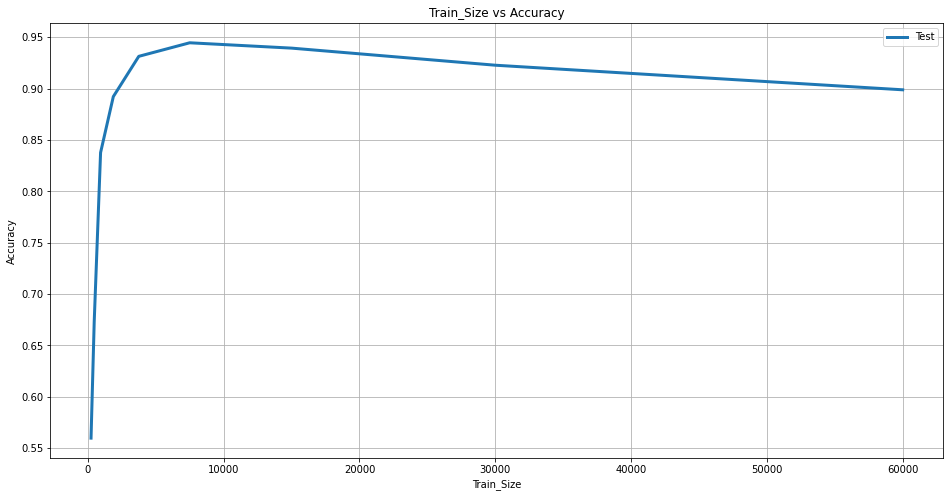

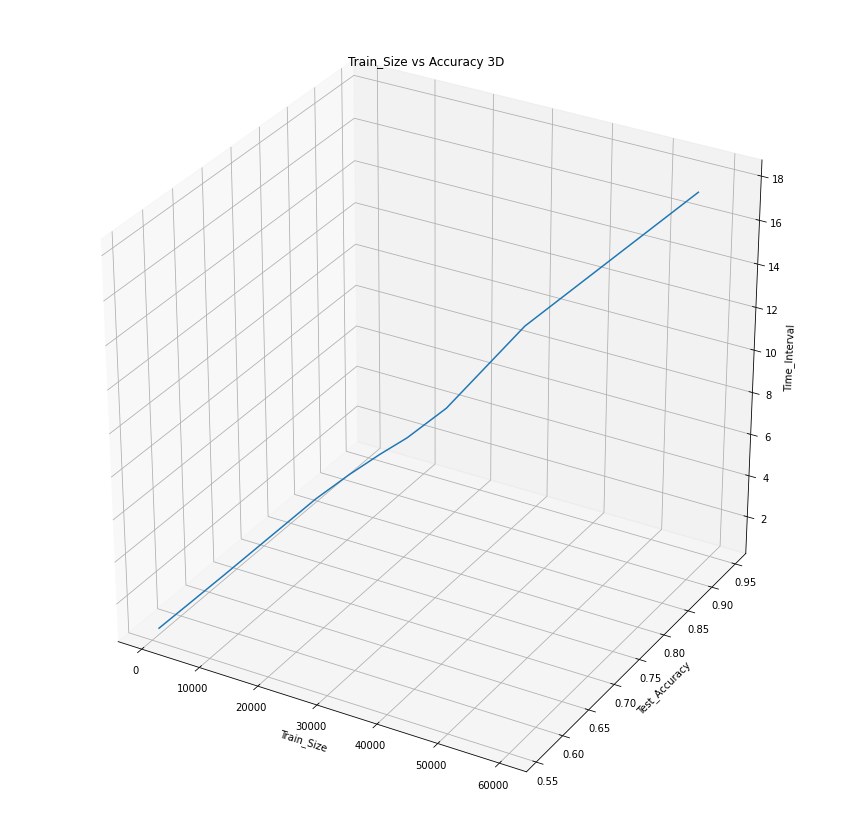

In [61]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
train_size = []
time_interval = []
depth_range = 10
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    train_size.append(Tn_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    clf_dt_depth = CategoricalNB()
    
    clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = clf_dt_depth.predict(X_train.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_train, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tn_S = Tn_S/2 
    Tn_S = int(Tn_S)
    time_interval.append(time.time()-ti)
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Train_Size vs Accuracy')
plt.xlabel('Train_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(train_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Train_Size vs Accuracy 3D')
ax.set_xlabel('Train_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(train_size,test_accuracy,time_interval)

Train Size: 60000 Test_Size: 10000
[0.9475]
Train Size: 1/6 and took 3.08s
Train Size: 60000 Test_Size: 5000
[0.9475, 0.9404]
Train Size: 2/6 and took 1.50s
Train Size: 60000 Test_Size: 2500
[0.9475, 0.9404, 0.914]
Train Size: 3/6 and took 1.30s
Train Size: 60000 Test_Size: 1250
[0.9475, 0.9404, 0.914, 0.824]
Train Size: 4/6 and took 1.08s
Train Size: 60000 Test_Size: 625
[0.9475, 0.9404, 0.914, 0.824, 0.7936]
Train Size: 5/6 and took 0.98s
CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)
Time elapsed: 20.50s


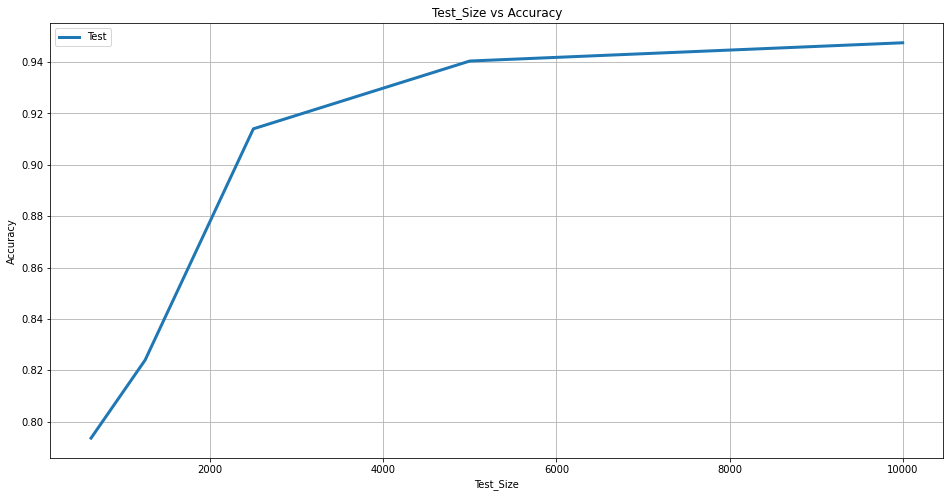

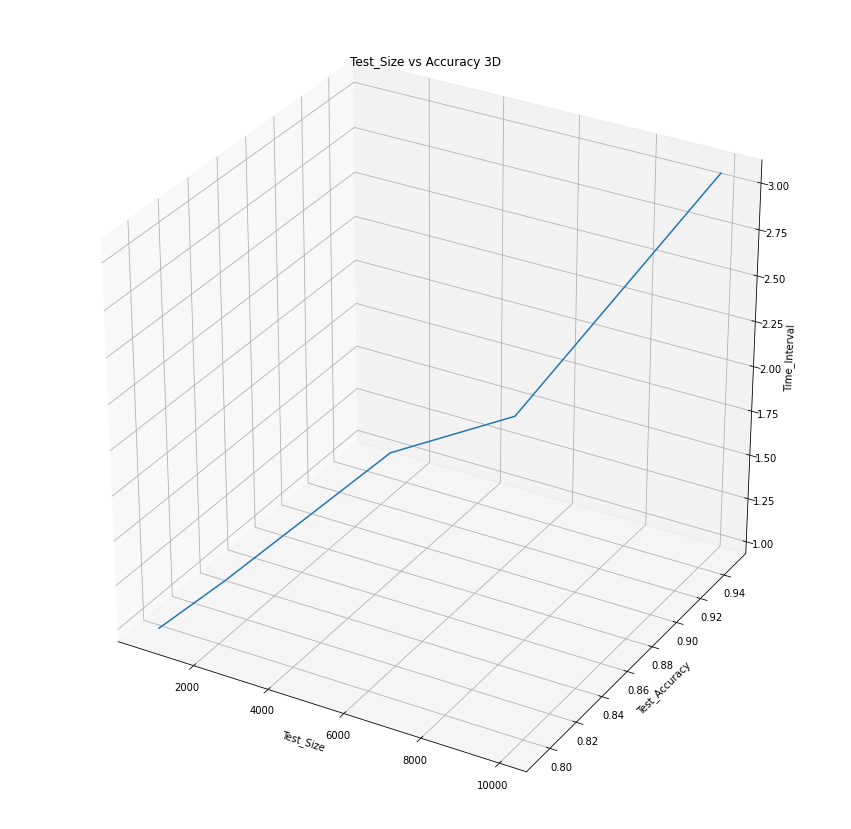

In [62]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
test_size = []
time_interval = []
depth_range = 6
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    test_size.append(Tt_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    clf_dt_depth = CategoricalNB()
    
    clf_dt_depth.fit(X_test.reshape(-1,28*28), y_test)
    
    test_pred_dt = clf_dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tt_S = Tt_S/2 
    Tt_S = int(Tt_S)
    time_interval.append(time.time()-ti)
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Test_Size vs Accuracy')
plt.xlabel('Test_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(test_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Test_Size vs Accuracy 3D')
ax.set_xlabel('Test_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(test_size,test_accuracy,time_interval)

In [12]:
correct_indices = np.nonzero(bnb_pre == y_test)[0]
incorrect_indices = np.nonzero(bnb_pre != y_test)[0]

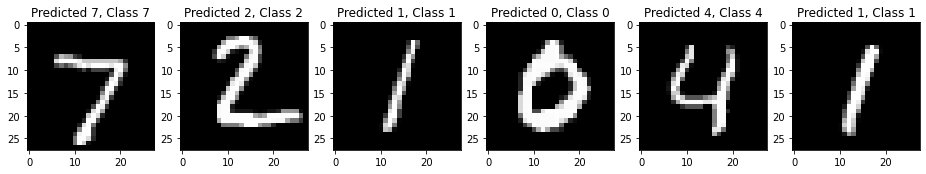

In [13]:
num_figures = 6
plt.figure(figsize=(16,8))
for i, correct in enumerate(correct_indices[:num_figures]):
    plt.subplot(1,num_figures,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(bnb_pre[correct], y_test[correct]))

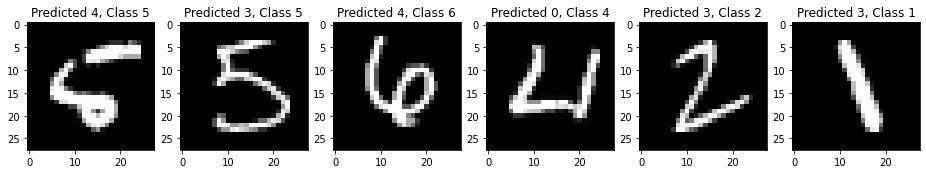

In [14]:
num_figures = 6
plt.figure(figsize=(16,8))
for i, incorrect in enumerate(incorrect_indices[:num_figures]):
    plt.subplot(1,num_figures,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(bnb_pre[incorrect], y_test[incorrect]))